In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
%matplotlib inline
import matplotlib
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow

import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

In [ ]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [34]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data1_dir = '/content/drive/MyDrive/Colab Notebooks/GTSRB_Train_sample3/training_sample3'
data2_dir = '/content/drive/MyDrive/Colab Notebooks/GTSRB_Train_sample2/training_sample2'

train_datasets = datasets.ImageFolder(os.path.join(data1_dir), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data2_dir), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=49, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=49, shuffle=True, num_workers=2)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 9654
테스트 데이터셋 크기: 1787
클래스: ['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042']


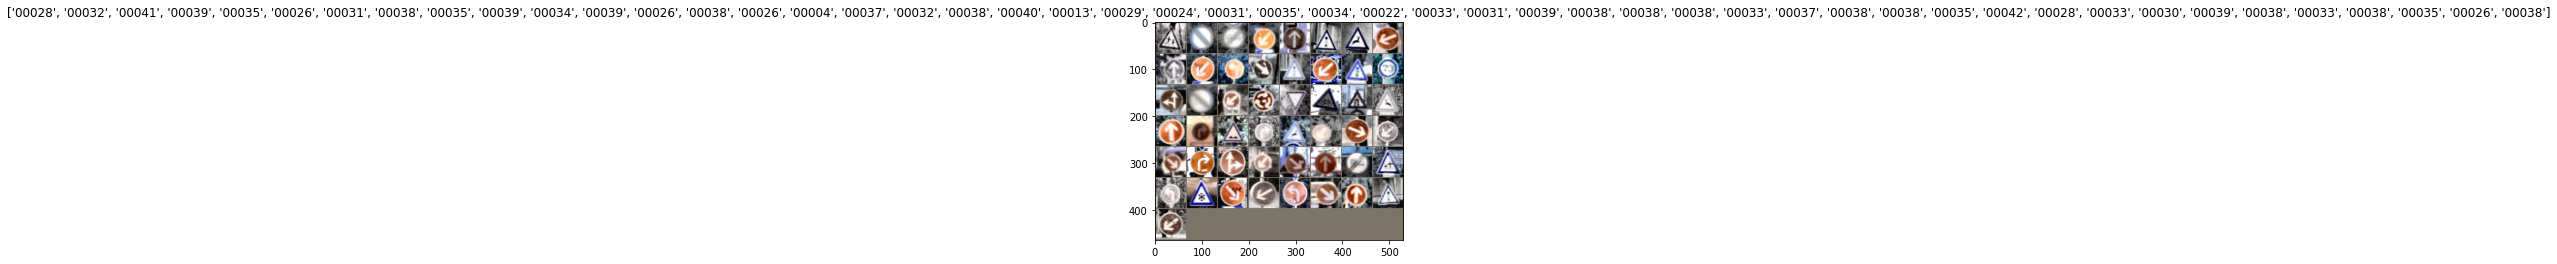

In [35]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
   
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [36]:
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 3개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 43)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
num_epochs = 200
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.
    
    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

#0 Loss: 0.0018 Acc: 99.9482% Time: 16.8759s
#1 Loss: 0.0007 Acc: 99.9793% Time: 32.2986s
#2 Loss: 0.0027 Acc: 99.9275% Time: 47.6432s
#3 Loss: 0.0016 Acc: 99.9586% Time: 63.2790s
#4 Loss: 0.0011 Acc: 99.9793% Time: 78.6968s
#5 Loss: 0.0017 Acc: 99.9689% Time: 94.1806s
#6 Loss: 0.0045 Acc: 99.8757% Time: 110.6689s
#7 Loss: 0.0031 Acc: 99.9068% Time: 126.2260s
#8 Loss: 0.0015 Acc: 99.9586% Time: 141.5564s
#9 Loss: 0.0013 Acc: 99.9793% Time: 157.0447s
#10 Loss: 0.0019 Acc: 99.9482% Time: 172.5730s
#11 Loss: 0.0016 Acc: 99.9275% Time: 188.0679s
#12 Loss: 0.0023 Acc: 99.9482% Time: 205.0108s
#13 Loss: 0.0021 Acc: 99.9482% Time: 220.6465s
#14 Loss: 0.0029 Acc: 99.9586% Time: 236.2840s
#15 Loss: 0.0009 Acc: 99.9896% Time: 252.0802s
#16 Loss: 0.0007 Acc: 99.9896% Time: 267.5216s
#17 Loss: 0.0009 Acc: 99.9793% Time: 282.9385s
#18 Loss: 0.0012 Acc: 99.9689% Time: 299.9545s
#19 Loss: 0.0008 Acc: 99.9689% Time: 315.6132s
#20 Loss: 0.0015 Acc: 99.9793% Time: 331.1581s
#21 Loss: 0.0008 Acc: 99.9896

[예측 결과: 00034] (실제 정답: 00016)


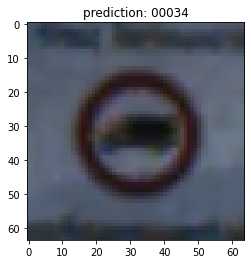

[예측 결과: 00040] (실제 정답: 00003)


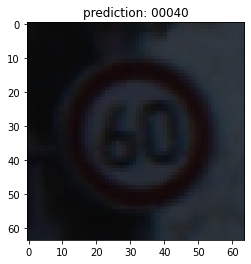

[예측 결과: 00024] (실제 정답: 00024)


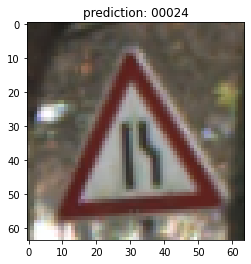

[예측 결과: 00035] (실제 정답: 00035)


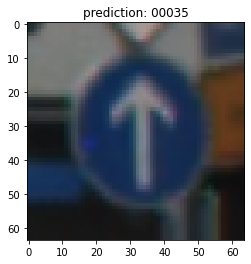

[예측 결과: 00028] (실제 정답: 00028)


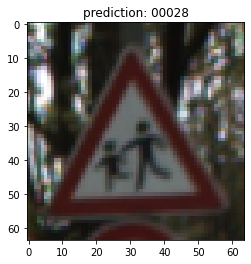

[예측 결과: 00041] (실제 정답: 00002)


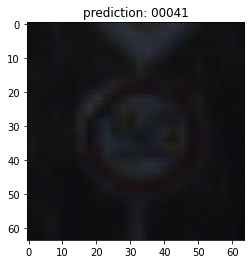

[예측 결과: 00030] (실제 정답: 00028)


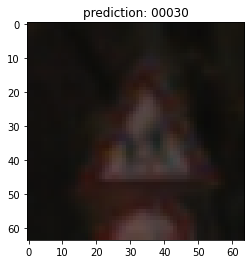

[예측 결과: 00028] (실제 정답: 00025)


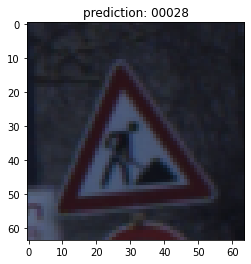

[예측 결과: 00034] (실제 정답: 00007)


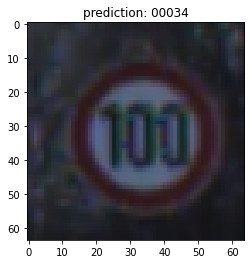

[예측 결과: 00013] (실제 정답: 00013)


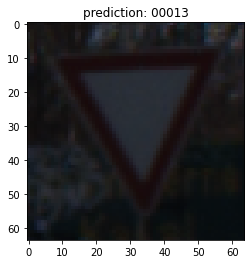

[예측 결과: 00042] (실제 정답: 00042)


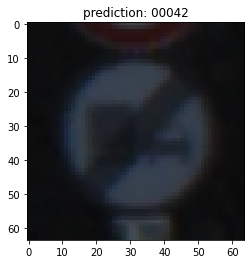

[예측 결과: 00041] (실제 정답: 00008)


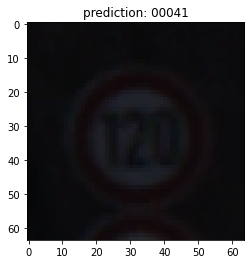

[예측 결과: 00008] (실제 정답: 00008)


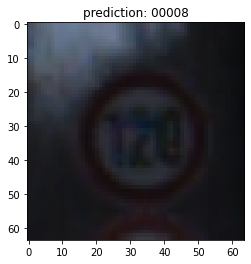

[예측 결과: 00041] (실제 정답: 00025)


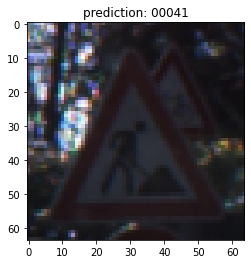

[예측 결과: 00038] (실제 정답: 00016)


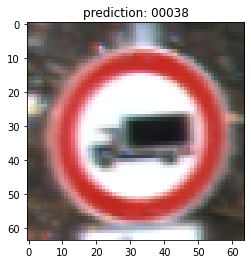

[예측 결과: 00038] (실제 정답: 00017)


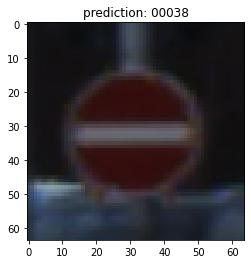

[예측 결과: 00030] (실제 정답: 00018)


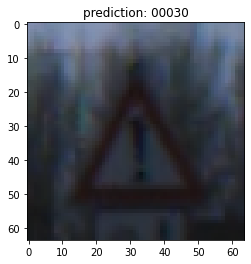

[예측 결과: 00023] (실제 정답: 00021)


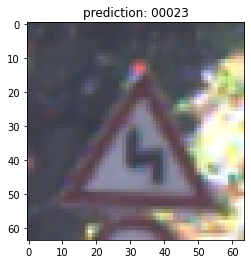

[예측 결과: 00028] (실제 정답: 00024)


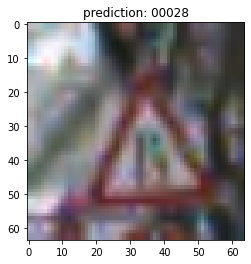

[예측 결과: 00034] (실제 정답: 00016)


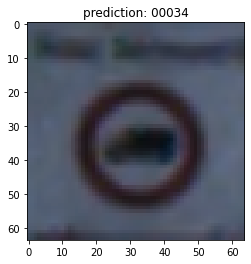

[예측 결과: 00029] (실제 정답: 00028)


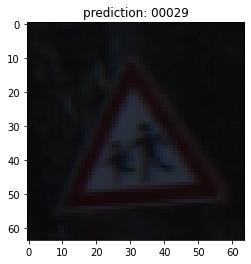

[예측 결과: 00041] (실제 정답: 00008)


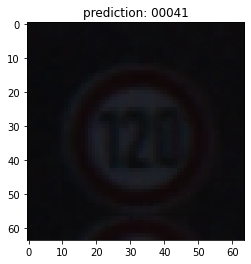

[예측 결과: 00042] (실제 정답: 00012)


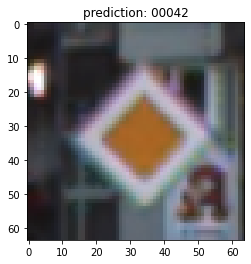

[예측 결과: 00034] (실제 정답: 00034)


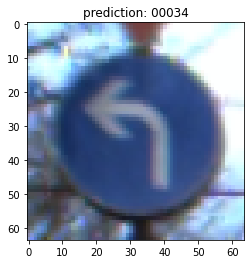

[예측 결과: 00034] (실제 정답: 00001)


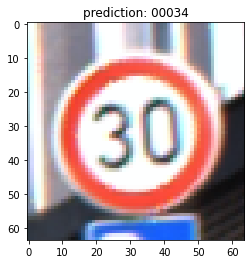

[예측 결과: 00041] (실제 정답: 00002)


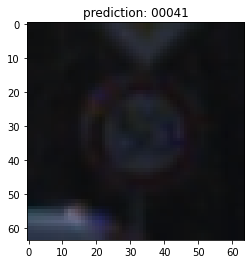

[예측 결과: 00035] (실제 정답: 00035)


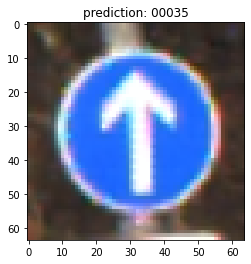

[예측 결과: 00031] (실제 정답: 00031)


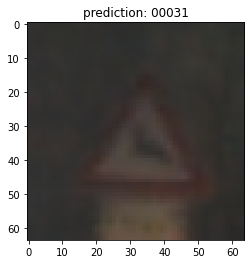

[예측 결과: 00031] (실제 정답: 00031)


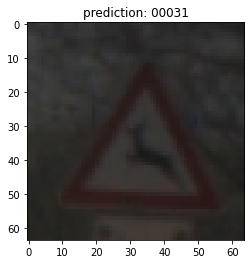

[예측 결과: 00027] (실제 정답: 00027)


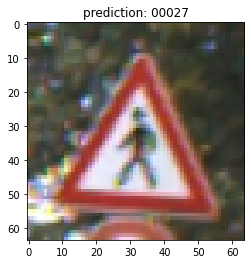

[예측 결과: 00008] (실제 정답: 00003)


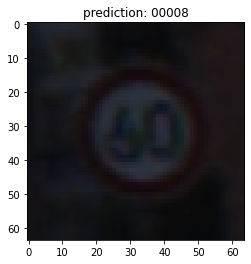

[예측 결과: 00038] (실제 정답: 00039)


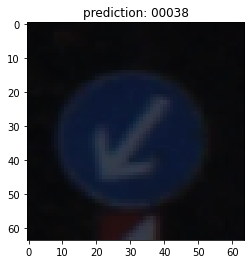

[예측 결과: 00028] (실제 정답: 00025)


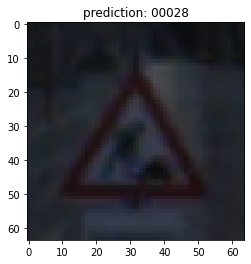

[예측 결과: 00041] (실제 정답: 00025)


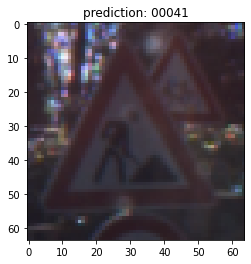

[예측 결과: 00030] (실제 정답: 00023)


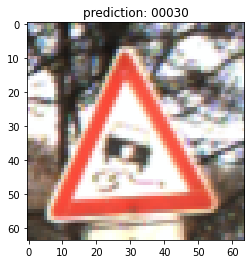

[예측 결과: 00034] (실제 정답: 00007)


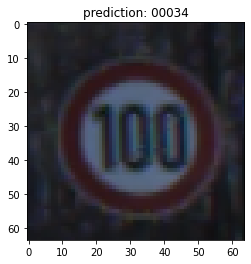

[예측 결과: 00034] (실제 정답: 00000)


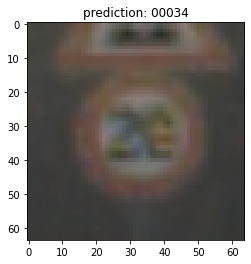

[Test Phase] Loss: 4.1061 Acc: 30.9457% Time: 7.5360s


In [40]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='prediction: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))